## Siamese Network for House Recommendation

##### Goal:
build `siamese network` and `triplet loss` to compare house feature embeddings and provide recommendations. 

##### Reference:
[Siamese Network Keras for Image and Text similarity](https://medium.com/@prabhnoor0212/siamese-network-keras-31a3a8f37d04)<br>
[Home Embeddings for Similar Home Recommendations](https://www.zillow.com/tech/embedding-similar-home-recommendation/)

#### STEP 0. Load in packages

In [2]:
!pip install tensorflow

In [31]:
!pip install seaborn

In [3]:
# import libraries
from __future__ import absolute_import
from __future__ import print_function

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Input, Dense, Lambda, Layer, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import Model


from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K


### STEP 1. Build Siamese Network

1. build siames algo in tf.keras, loss function
2. dataset from (cos-similarity algo)
3. train, validate
4. demo
5. *skip-gram "NLP" instead of one-hot

#### 1.1 Build Model

<img src="https://miro.medium.com/max/1050/1*jQcJ7ik58aeTV0As2d9Jcw.png" width="400">

##### Triplet Loss

Anchor is the house listing we are working at, positive include the listings that have been seen and negative include the listings haven't been seen.

In [9]:
def cosine_distance(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return -K.mean(x * y, axis=-1, keepdims=True)
  
  
def get_siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        
        Consider add in:
          kernel_initializer=initialize_weights,
          bias_initializer=initialize_bias
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    ### Convert to 1 D dataset 
    embedd_model = Sequential()
    embedd_model.add(Dense(8, activation='relu', input_shape=input_shape, name='dense1'))
    embedd_model.add(Dropout(.2))
    embedd_model.add(Dense(6, activation='sigmoid', kernel_regularizer=l2(2e-4), name='dense2'))
    embedd_model.add(Dropout(.2))
    # embedd_model.add(Dense(64, activation='relu', kernel_regularizer=l2(2e-4), name='dense3'))
    # embedd_model.add(Dropout(.2))
    # embedd_model.add(Dense(64, activation='relu', kernel_regularizer=l2(2e-4), name='dense4'))
    # embedd_model.add(Dropout(.2))
    # embedd_model.add(Dense(16, activation='sigmoid',kernel_regularizer=l2(1e-3), name='dense5'))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = embedd_model(left_input)
    encoded_r = embedd_model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    # L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    print("Calucate lambda cosine distance")
    L1_layer = Lambda(cosine_distance)
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net


def evaluate_model(model,test_data, training_results):
    
    # Get the model train history
    model_train_history = training_results.history
    # Get the number of epochs the training was run for
    num_epochs = len(model_train_history["loss"])

    # Plot training results
    fig, ax = plt.subplots(figsize=(15,5))
    plt.title('Loss')
    # Plot all metrics
    for metric in ["loss","val_loss"]:
        plt.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    plt.legend()
    
    plt.show()
    
    # Evaluate on test data
    evaluation_results = model.evaluate(test_data)
    print("Evaluation Results:", evaluation_results)

  
# [pos1, pos2, pos3, neg1, neg2, neg3, ori]
# pos1: 1 x K vector
def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)

    alpha - like a positive margin m (between 0 and 2) enables the training to focus on the challenging cases (hard negatives).
    Returns:
    loss -- real number, value of the loss
    """
   #For each row, positive list is the first index
    positive =y_pred[:3] #list of len 3

    #For each row, negative list is the first index
    negative = y_pred[3:6] #list of len 3

    #For each row, anchor is the last index
    anchor = y_pred[-1:] #list of len 1
    
    
    # distance between the anchor and the positive
    
    pos_dist = K.square(anchor-positive)
    pos_dist = K.sum(tf.where(tf.math.is_nan(pos_dist), tf.zeros_like(pos_dist), pos_dist),axis=-1)

    # distance between the anchor and the negative
    neg_dist = K.square(anchor-negative)
    neg_dist = K.sum(tf.where(tf.math.is_nan(neg_dist), tf.zeros_like(neg_dist), neg_dist),axis=-1)

    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.sum(K.maximum(basic_loss,0.0))
 
    return loss

#### 1.2 train, validate

1.2.1 Drop columns with too many NA values

In [11]:
# read in dataset
df = pd.read_csv("listings_with_rexurl.csv")

df_rmna = df.replace(0, pd.np.nan).dropna(axis=1, thresh=int(df.shape[0]*0.7))
df_rmna['rexUrl'] = df['rexUrl']
df_rmna.head(2)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


,latitude_y,longitude_y,bedrooms,land_square_footage,living_square_feet,stories,total_baths,year_built,rexUrl,country_code2_US,marketing_budget_MEDIUM,property_type_SINGLE,artificial_listing_id
0,0.712941,0.355994,0.190476,0.003478,0.009007,NaN,0.060747,0.918519,384-woodson-dr,NaN,1.0,1.0,NaN
1,0.744977,0.944363,0.285714,0.005028,0.016939,0.111111,0.072945,0.744444,139-belmill-rd,NaN,1.0,1.0,1.0


In [ ]:
df_rmna.to_csv("listings_drop_na.csv", index=False)

1.2.2 Loading in Updated Y Data (NA/Zeros Removed)

In [12]:
# Load in Y data [[pos pos pos] [neg neg neg] anchor]
y_metadata = np.load('y_meta_numpy.npy',allow_pickle=True)

# prepare y label
y_pos_1 = np.stack(y_metadata[:,0].ravel())[:,0,:]
y_pos_2 = np.stack(y_metadata[:,0].ravel())[:,1,:]
y_pos_3 = np.stack(y_metadata[:,0].ravel())[:,2,:]

y_neg_1 = np.stack(y_metadata[:,1].ravel())[:,0,:]
y_neg_2 = np.stack(y_metadata[:,1].ravel())[:,1,:]
y_neg_3 = np.stack(y_metadata[:,1].ravel())[:,2,:]

y_anchor = np.stack(y_metadata[:,2].ravel())

y_all = np.array([y_pos_1, y_pos_2, y_pos_3, y_neg_1, y_neg_2, y_neg_3, y_anchor])
# Making dummy labels of 1 and 0
label_arr = []
for _ in range(int(len(y_pos_1)/2)):
    label_arr += [1.0, 0.0]

label_arr = np.array(label_arr)
print("Label shape: ", label_arr.shape)

Label shape:  (702,)


---

1.2.3 Generate house input X, y

In [18]:
# get house metadata X
x_data = y_all[-1]
y_data = np.array(y_all).reshape((-1, 7, 10))

# prepare house1 data and house2 data
x_data_1 = x_data.copy()
idx = np.arange(len(x_data))
np.random.shuffle(idx)
x_data_2 = x_data[idx]

# fill nan in the data
x_data_1 = np.nan_to_num(x_data_1)
x_data_2 = np.nan_to_num(x_data_2)
y_data = np.nan_to_num(y_data)

x_data_1.shape, x_data_2.shape,y_data.shape

((702, 10), (702, 10), (702, 7, 10))

In [19]:
# split train and test
train_size = int(len(x_data)*0.8)
train_data = tf.data.Dataset.from_tensor_slices(((x_data_1[:train_size], x_data_2[:train_size]), y_data[:train_size]))
train_data = train_data.batch(64)


test_data = tf.data.Dataset.from_tensor_slices(((x_data_1[train_size:], x_data_2[train_size:]), y_data[train_size:]))
test_data = test_data.batch(64)

train_data

<BatchDataset shapes: (((None, 10), (None, 10)), (None, 7, 10)), types: ((tf.float64, tf.float64), tf.float64)>

1.2.4 Fake input X, y

In [20]:
s = 100
input_array = np.random.randint(1000, size=(s,10))
input_y = np.random.normal(1, size=(s,7,10))
input_array.shape, input_y.shape

((100, 10), (100, 7, 10))

In [21]:
train_data_fk = tf.data.Dataset.from_tensor_slices(((input_array, input_array), input_y))
train_data_fk = train_data_fk.batch(64)
train_data_fk

<BatchDataset shapes: (((None, 10), (None, 10)), (None, 7, 10)), types: ((tf.int64, tf.int64), tf.float64)>

#### 1.3 Train the Model

In [22]:
# Compile model
siamese_model = get_siamese_model((10,))
optimizer = Adam(lr = 0.0001)
## add in triplet loss funciton 
siamese_model.compile(loss=triplet_loss,optimizer='adam')
print(siamese_model.summary())

# Train model
training_results = siamese_model.fit(train_data, validation_data=test_data, 
                                     epochs=20,  batch_size=64, shuffle=True, verbose=1)

Calucate lambda cosine distance
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 6)            142         input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0 

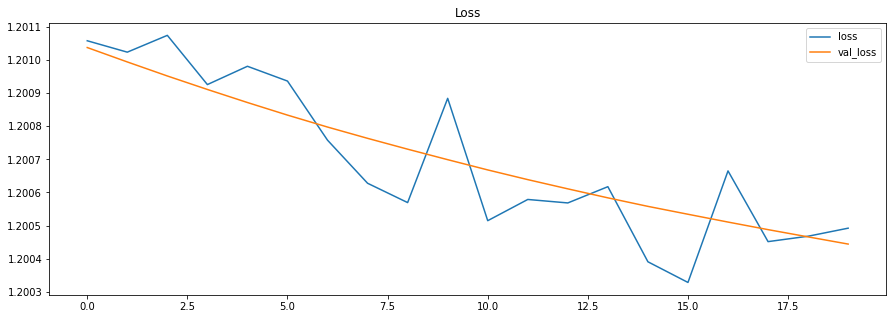

3/3 [==============================] - 0s 1ms/step - loss: 1.2004
Evaluation Results: 1.200443983078003


In [25]:
evaluate_model(siamese_model,test_data, training_results)

#### 1.4 Demo

Extract the embedding layer from the trained siamese model

In [26]:
embedding_func = K.function(inputs = siamese_model.layers[2].input, outputs = siamese_model.layers[2].output)

In [27]:
def similarity_between_embeddings(a,b):
    h1 = embedding_func(np.expand_dims(x_data_1[a],axis=0))
    h2 = embedding_func(np.expand_dims(x_data_1[b],axis=0))

    return metrics.pairwise.cosine_similarity(h1,h2)[0][0]

In [28]:
# compare the house 1 and house 2 in the dataset
similarity_between_embeddings(1,2)

0.9992071

Load in house meta data and calcuate the similary between each house

In [29]:
listings_data = np.load('listings_metadata.npy',allow_pickle=True)
rexUrls = np.load('rexUrls.npy',allow_pickle=True)

# fill na
listings_data = np.nan_to_num(listings_data,)

<AxesSubplot:>

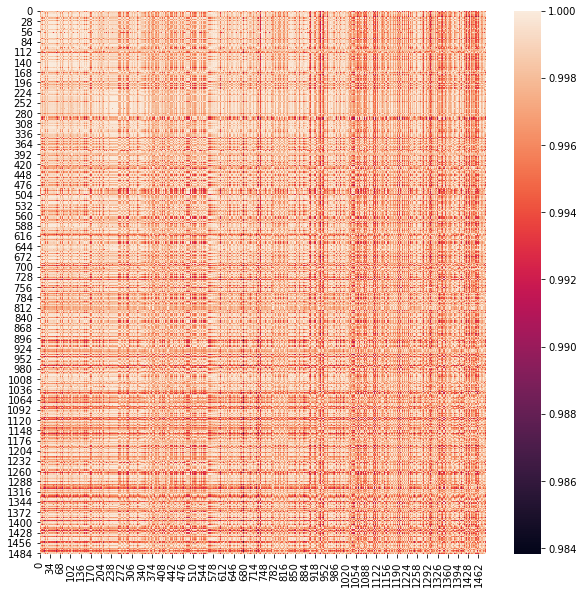

In [33]:
# run embedding to each house metadata
embedding_all_data = []
for i in range(listings_data.shape[0]):
    embedding_i = embedding_func(np.expand_dims(listings_data[i],axis=0))
    embedding_all_data.append(embedding_i)

embedding_all_data = np.array(embedding_all_data)
embedding_all_data = np.squeeze(embedding_all_data)

# calcuate pairwise cosine similarity between embeddings
csims = metrics.pairwise.cosine_similarity(embedding_all_data)

# plot
plt.figure(figsize=(10,10))
sns.heatmap(csims)
plt.show()

Find most similar houses

In [34]:
most_sims = []
for row in range(len(csims)):
    curr_row = np.delete(csims[row],row)
    most_sims.append(np.argmax(curr_row))

In [35]:
similarities = pd.DataFrame(data={'rexUrl':rexUrls, 'most_similar':rexUrls[most_sims]})
similarities.head()

,rexUrl,most_similar
0,384-woodson-dr,201-hand-ave
1,139-belmill-rd,69-bayberry-dr
2,552-mermaid-ave,14-downey-pl
3,610-los-trancos-rd,249-franklin-rd
4,431-n-union-st,12-s-washington-ave-apt-2


##### *run on fake data

In [ ]:
siamese_model = get_siamese_model((10,))
optimizer = Adam(lr = 0.0001)
## add in triplet loss funciton 
siamese_model.compile(loss=triplet_loss,optimizer=optimizer)

print(siamese_model.summary())

training_results = siamese_model.fit(train_data_fk, validation_data=train_data_fk, epochs=5,  
                                     batch_size=64, shuffle=True, verbose=1)

Calucate lambda cosine distance
Model: "functional_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_95 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_96 (InputLayer)           [(None, 10)]         0                                            
__________________________________________________________________________________________________
sequential_47 (Sequential)      (None, 16)           31376       input_95[0][0]                   
                                                                 input_96[0][0]                   
__________________________________________________________________________________________________
lambda_45 (Lambda)              (None, 1)            0

In [ ]:
# Adapted from lec
def plot_history(model_fit):
  # Get the model train history
  model_train_history = model_fit.history

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(8,5))
  axs = fig.add_subplot(1,1,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()


  plt.show()

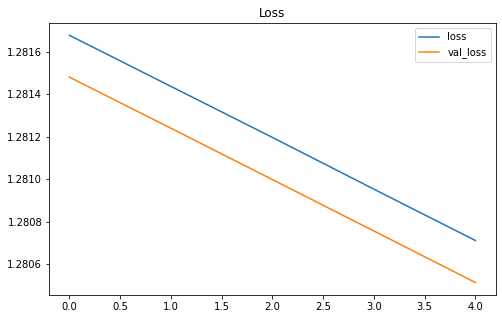

In [ ]:
plot_history(training_results)